In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
import pandas as pd
import matplotlib.dates as mpl_dates
import scipy.stats as stats
from matplotlib.ticker import StrMethodFormatter 

### Functions

In [2]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = age
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var

def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

def running_mean(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)

### Import data

In [3]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [4]:
#Importing data and calculating section transport 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

files = ['forpr_haro3','backvs_haro3']
        #  'forvs_haro3','backpr_haro3','backgulf_haro3']
namen = ['datafvs']

starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5,6,7,8]

date = dt.datetime(2021,12,10)
enddate = dt.datetime(2022,12,28)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     
dicts = {}

for i,file in enumerate(files):
    dict_i = {}
    
    for date in dates:
        name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/' + date + '_s1t50/ariane_positions_quantitative.nc'
        
        if os.path.isfile(name):
            dict_i[date] = xr.open_dataset(name)
        
    dicts[file] = dict_i
    
dict_sectiontransp = {}

for file in files:
    st_dict = {}
    for var in dicts[file].keys():
        if var not in st_dict:
            st_dict[var] = []
        for section in sectionnum:
            st_dict[var].append(get_datat(dicts[file][var],section,starttime,endtime))
        dict_sectiontransp[file] = st_dict

dict_age = {}

for file in files:
    a_dict = {}
    
    for date in dicts[file].keys():
        if date not in a_dict:
            a_dict[date] = []
        for section in sectionnum:
            allvar = get_secdata(dicts[file][date],section)
            a_dict[date].append(np.mean(allvar['final_age'][allvar['final_age']>=24]))
    dict_age[file] = a_dict

age_2018 = {}

for file in files:
    
    if file not in age_2018:
        age_2018[file] = {}
    
    for section in sectionnum:
        
        if section not in age_2018[file]:
            
            age_2018[file][section] = []
            
        for date in dicts[file].keys():
            
            age_2018[file][section].append(dict_age[file][date][section])
            
transp_2018 = {}

for file in files:
    
    transp_2018[file] = []
    
    for date in dates:
        try:
            transp_2018[file].append(np.sum(dict_sectiontransp[file][date][2:]))
        except:
            pass
        
sectransp_2018 = {}

for file in files:
    sectransp_2018[file] = {}
    
    for section in sectionnum:
        if section not in sectransp_2018[file]:
            sectransp_2018[file][section] = []
            
        for date in dates:
            try:
                sectransp_2018[file][section].append(dict_sectiontransp[file][date][section])
            except:
                pass


In [5]:
dict_secdata = {}
sectionnum = [0,1,2,3,4,5,6,7,8]

for file in files:
    
    if file not in dict_secdata:
        dict_secdata[file] = {}
    
    for section in sectionnum:
        
        if section not in dict_secdata[file]:
            
            dict_secdata[file][section] = {}
            
        for date in dicts[file].keys():
            
            if section not in dict_secdata[file]:
            
                dict_secdata[file][section][date] = {}
            
            dict_secdata[file][section][date] = get_secdata(dicts[file][date],section)

In [6]:
prtovs_haro_sal = []
prtovs_haro_temp = []

for date in dict_secdata['forpr_haro3'][6].keys():
    prtovs_haro_sal.append(np.mean(dict_secdata['forpr_haro3'][6][date]['final_salt'].values))
    prtovs_haro_temp.append(np.mean(dict_secdata['forpr_haro3'][6][date]['final_temp'].values))

### Shifting Functions

In [7]:
def shift_time(dfr,dfr_age,datelist,base,factor):
    shifted_time = [date + dt.timedelta(days=base+factor*dfr_age[i]/24) for i,date in enumerate(datelist)]
    dfr = pd.DataFrame({'Transport':dfr.values,'Shifted_Time': shifted_time},index=dfr.index)
    return dfr

def merge(dfr,dfr2):
    """Aligns shifted dateframes to calculate correlation

    Args:
        dfr : Forward dataframe
        dfr2 (_type_): Backward dataframe

    Returns:
        _type_: Aligned, shifted dataframes and correlation between the 2.
    """
    
    oidx = dfr.index
    ndfr = dfr.set_index('Shifted_Time')
    nidx = ndfr.index
    
    step1 = ndfr.reindex(nidx.union(oidx)) # Creates dataframe with row of each old and new index ( no overlap - 128 rows now)
    step2 = step1.sort_index() # Sorts into chronological order
    step3 = step2.interpolate(axis=0) # Interpolates in between (since dates dont line up)
    fdfr = step3
    
    #Same for 2nd dataframe
    oidx2 = dfr2.index
    ndfr2 = dfr2.set_index('Shifted_Time')
    nidx2 = ndfr2.index
    
    step1 = ndfr2.reindex(nidx2.union(oidx2))
    step2 = step1.sort_index()
    step3 = step2.interpolate(axis=0)
    fdfr2 = step3
    
    corr = fdfr.Transport.corr(fdfr2.Transport) #Correlation ignores nan values
    
    avg = 0.5*(fdfr.Transport + fdfr2.Transport)
    return fdfr,fdfr2,corr,avg

### Importing density difference, tides, winds

In [8]:
# Importing density and tidal data

density_ros = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_2016-22_rosarioNS.csv')
dens_diff_ros = np.array(density_ros.south - density_ros.north)

density_vspr = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_2016-22_202111_mean.csv')
dens_diff_vspr = np.array(density_vspr.south - density_vspr.north)

tides_1d = pd.read_csv('../notebooks/day_avg_tide_BP_16-22.csv')
tides = tides_1d['vozocrtx'].rolling(4, center=True).mean()
# tides_ros = pd.read_csv('low_pass_tide_18-22.csv')

date = dt.datetime(2016,1,1)
enddate = dt.datetime(2022,12,31)
datelist_tides = []

while date <= enddate:
    datelist_tides.append(date)
    date+=dt.timedelta(days=1)

#Confirm dates are same length

print(len(datelist_tides))
print(tides.shape)   
 
date = dt.datetime(2016,1,1)
enddate = dt.datetime(2022,12,31)
datelist_dens = []

while date <= enddate:
    datelist_dens.append(date)
    date+=dt.timedelta(days=1)
    
dens_diff_ros
print(len(datelist_dens),)
print(len(dens_diff_vspr))

2557
(2557,)
2557
2557


In [9]:
wind = pd.read_csv('../notebooks/day_avg_wind_16-22.csv')
x = wind['time']
y = wind['wind']

date = dt.datetime(2016,1,1)
enddate = dt.datetime(2022,12,31)
datelist_winds = []

while date <= enddate:
    datelist_winds.append(date)
    date+=dt.timedelta(days=1)
    
y_mean4 = y.rolling(window=4, center=True).mean()

In [10]:
len(datelist_winds),len(y_mean4)

(2557, 2557)

### PR to VS through Haro

In [11]:
PRtovs_harol = sectransp_2018['forpr_haro3'][6]
PRtovs_harobl = sectransp_2018['backvs_haro3'][6]

PRtovs_haro = pd.Series(PRtovs_harol,index=datelist_vs)
PRtovs_harob = pd.Series(PRtovs_harobl,index=datelist_vs)

In [12]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs_haro,age_2018['forpr_haro3'][6],datelist_vs,base,factor)
        dfr2 = shift_time(PRtovs_harob,age_2018['backvs_haro3'][6],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.66:
            print (base, factor, corr_arr[i, j])

In [13]:
i_base_vs_haro,i_factor_vs_haro = np.where(corr_arr==np.max(corr_arr))

base_vs_haro = base_arr[i_base_vs_haro]
factor_vs_haro = factor_arr[i_factor_vs_haro]

print(base_vs_haro,factor_vs_haro)

[-0.55] [0.25]


0.529323582215278


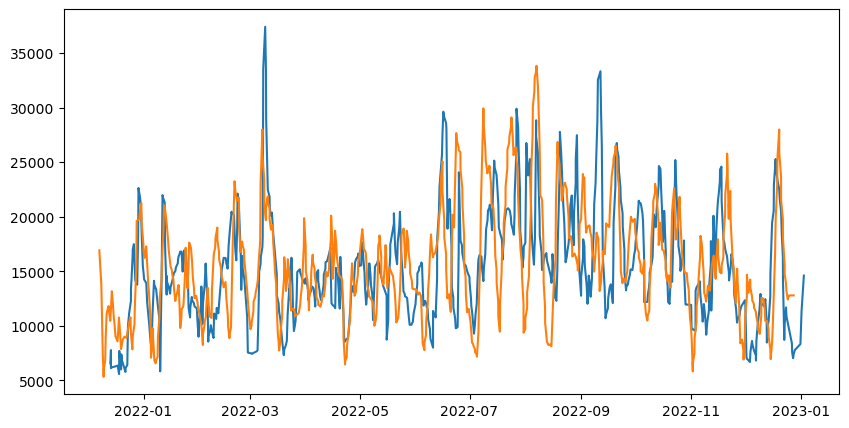

In [14]:
PRtovs_haro_sh = shift_time(PRtovs_haro,age_2018['forpr_haro3'][5],datelist_vs,base_vs_haro[0],factor_vs_haro[0])
PRtovs_harob_sh = shift_time(PRtovs_harob,age_2018['backvs_haro3'][6],datelist_vs,-base_vs_haro[0],-factor_vs_haro[0])

PRtovs_haro_m,PRtovs_harob_m,c,PRtovs_haro_avg = merge(PRtovs_haro_sh,PRtovs_harob_sh)
print(c)
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(PRtovs_haro_m.Transport)
ax.plot(PRtovs_harob_m.Transport)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


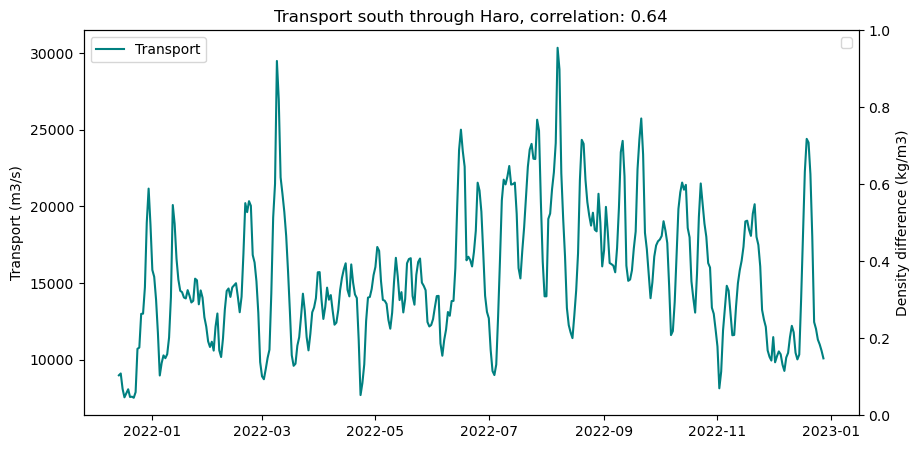

In [15]:
date_haro = list(PRtovs_haro_avg.dropna().index)

mask = np.isin(datelist_dens,date_haro)
densdiff_prtovs = dens_diff_vspr[mask]
date_dens_haro_sh = np.array(datelist_dens)[mask]

corr_prtovs,p = stats.spearmanr(densdiff_prtovs,PRtovs_haro_avg.dropna())

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(PRtovs_haro_avg.dropna(),color='teal',label='Transport')
ax2=ax.twinx()
# ax2.plot(date_dens_haro_sh,densdiff_prtovs,color='k',label='Density difference')
ax.set_title(f'Transport south through Haro, correlation: {np.round(corr_prtovs,2)}')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
ax.legend(loc=2)
ax2.legend()

In [16]:
slope,intercept = np.polyfit(densdiff_prtovs,PRtovs_haro_avg.dropna(),1)
ddline_prtovs = slope*densdiff_prtovs+intercept
res_prtovs = PRtovs_haro_avg.dropna() - ddline_prtovs

## Get tides
mask = np.isin(datelist_tides,date_haro)
tides_prtovs = tides[mask]

380
0.2644127418409224
-0.22920766691415342


Text(0.5, 1.0, 'PrtoVS through Haro')

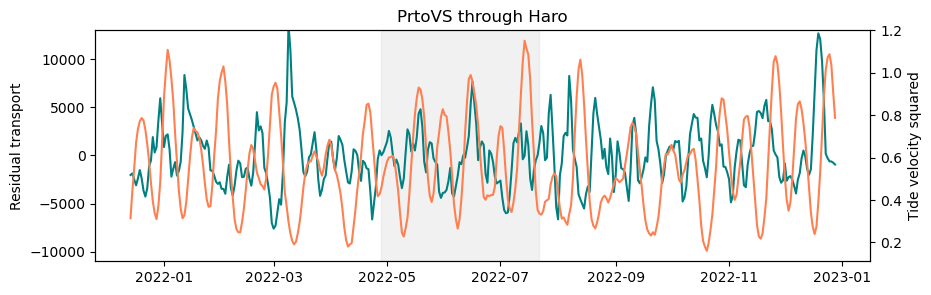

In [17]:
print(len(PRtovs_haro_avg.dropna()))

corr_prtovs,p = stats.spearmanr(tides_prtovs[135:220],res_prtovs[135:220])
print(corr_prtovs)

corr_prtovs_full,p = stats.spearmanr(tides_prtovs,res_prtovs)
print(corr_prtovs_full)

fig,ax = plt.subplots(figsize=(10,3))

ax.plot(res_prtovs,color='teal')
ax2 = ax.twinx()
ax2.plot(date_haro,tides_prtovs,color='coral')
ax.set_ylim((-11000,13000))
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_haro[135],x2=date_haro[220],color='lightgrey', alpha=0.3)
ax.set_ylabel('Residual transport')
ax2.set_ylabel('Tide velocity squared')
ax.set_title('PrtoVS through Haro')